In [6]:
# Script to visualize raw and preprocessed data
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# Resolve project root by searching upward for 'pyproject.toml' 
# (prioritize pyproject.toml over just finding a 'data' folder)
cwd = Path.cwd()
project_root = None

# First, look for pyproject.toml
for p in [cwd] + list(cwd.parents):
    if (p / 'pyproject.toml').exists():
        project_root = p
        break

# Fallback: search for the data/raw/train directory structure
if project_root is None:
    for p in [cwd] + list(cwd.parents):
        if (p / 'data' / 'raw' / 'train').is_dir():
            project_root = p
            break

if project_root is None:
    project_root = cwd

data_raw_train = project_root / 'data' / 'raw' / 'train'
clinical_path = data_raw_train / 'clinical_train.csv'
molecular_path = data_raw_train / 'molecular_train.csv'
target_path = data_raw_train / 'target_train.csv'

print(f"Project root: {project_root}")
print(f"Looking for data at: {data_raw_train}")

if not target_path.exists():
    raise FileNotFoundError(f'Could not find target file at {target_path}')
if not clinical_path.exists():
    raise FileNotFoundError(f'Could not find clinical file at {clinical_path}')
if not molecular_path.exists():
    raise FileNotFoundError(f'Could not find molecular file at {molecular_path}')

data_target = pd.read_csv(str(target_path), sep=',', header=0,
                       names=['ID','OS_YEARS','OS_STATUS'],
                       dtype={'ID': str, 'OS_YEARS': float, 'OS_STATUS': float})

data_clinical_features = pd.read_csv(str(clinical_path), sep=',', header=0,
    names=['ID','CENTER','BM_BLAST','WBC','ANC','MONOCYTES','HB','PLT','CYTOGENETICS'],
    dtype={'ID': str, 'CENTER': str, 'BM_BLAST': float, 'WBC': float, 'ANC': float, 'MONOCYTES': float, 'HB': float, 'PLT': float, 'CYTOGENETICS': str})

data_molecular_features = pd.read_csv(str(molecular_path), sep=',', header=0,
    names=['ID','CHR','START','END','REF','ALT','GENE','PROTEIN_CHANGE','EFFECT','VAF','DEPTH'],
    dtype={'ID': str, 'CHR': str, 'START': float, 'END': float, 'REF': str, 'ALT': str, 'GENE': str, 'PROTEIN_CHANGE': str, 'EFFECT': str, 'VAF': float, 'DEPTH': float})

Project root: c:\Users\alexb\Documents\EI3\APST1\Data Challenge\project_root
Looking for data at: c:\Users\alexb\Documents\EI3\APST1\Data Challenge\project_root\data\raw\train


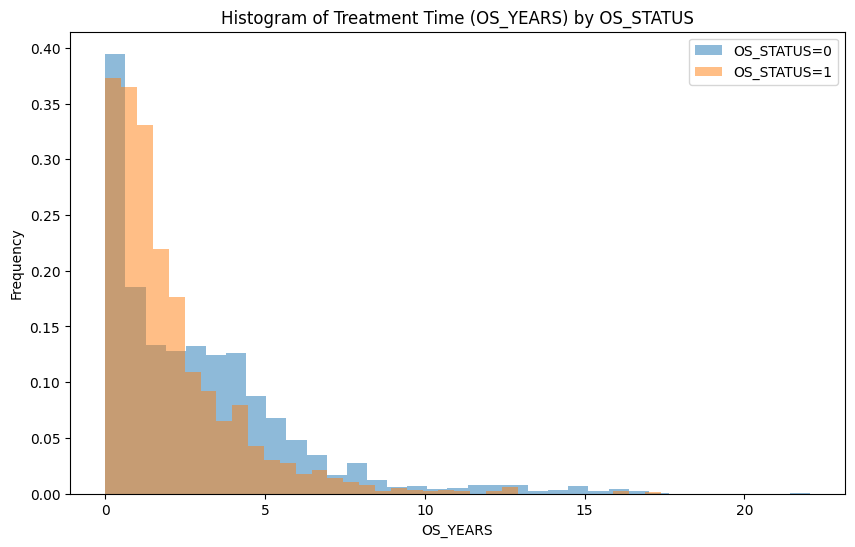

In [7]:
# Here we are plotting the normalized density of Treatment time (OS_YEARS) conditioned on OS_STATUS

plt.figure(figsize=(10, 6))
for status, group in data_target.groupby('OS_STATUS'):
    plt.hist(group['OS_YEARS'], bins=35, alpha=0.5, label=f'OS_STATUS={int(status)}', density=True)
plt.xlabel('OS_YEARS')
plt.ylabel('Frequency')
plt.title('Histogram of Treatment Time (OS_YEARS) by OS_STATUS')
plt.legend()
plt.show()


Original data: 3323 rows
After removing NaN: 2969 rows


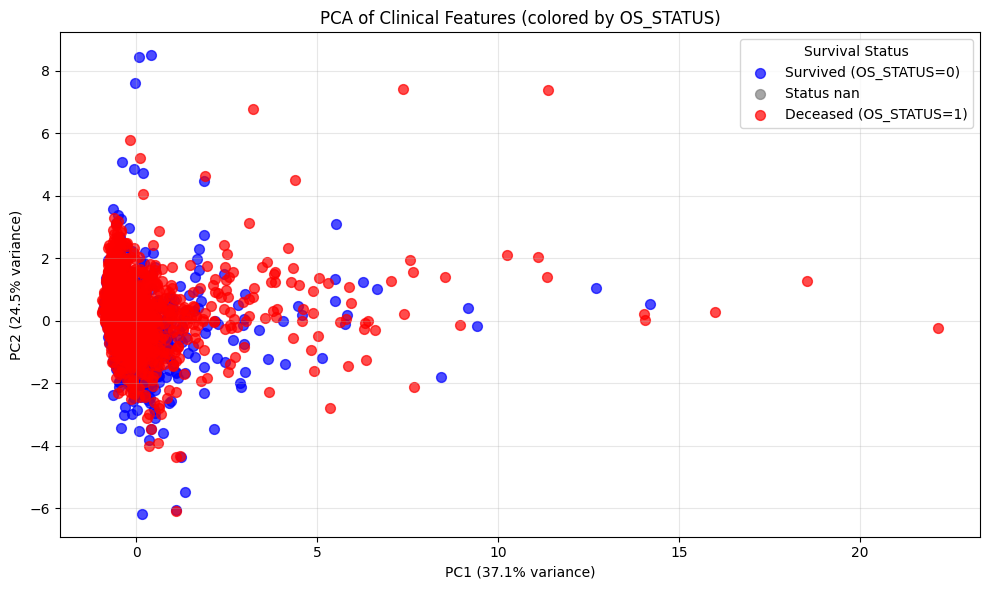

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ["BM_BLAST", "WBC", "ANC", "HB", "PLT"]

# Create a clean dataset by dropping rows with missing values in the selected features
data_clean = data_clinical_features[["ID", "CENTER"] + features].dropna()

# Merge with target data to get OS_STATUS
data_clean = data_clean.merge(data_target[["ID", "OS_STATUS"]], on="ID", how="left")

print(f"Original data: {len(data_clinical_features)} rows")
print(f"After removing NaN: {len(data_clean)} rows")

X = StandardScaler().fit_transform(data_clean[features])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot colored by OS_STATUS
plt.figure(figsize=(10, 6))
status_labels = {0.0: "Survived (OS_STATUS=0)", 1.0: "Deceased (OS_STATUS=1)"}
colors = {0.0: "blue", 1.0: "red"}

for status in sorted(data_clean["OS_STATUS"].unique()):
    mask = data_clean["OS_STATUS"] == status
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                label=status_labels.get(status, f"Status {status}"),
                color=colors.get(status, "gray"),
                alpha=0.7, s=50)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.title("PCA of Clinical Features (colored by OS_STATUS)")
plt.legend(title="Survival Status", loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

X_tsne = TSNE(perplexity=30, random_state=42, max_iter=1000).fit_transform(X)

# Create scatter plot colored by OS_STATUS
plt.figure(figsize=(10, 6))
status_labels = {0.0: "Survived (OS_STATUS=0)", 1.0: "Deceased (OS_STATUS=1)"}
colors = {0.0: "blue", 1.0: "red"}

for status in sorted(data_clean["OS_STATUS"].unique()):
    mask = data_clean["OS_STATUS"] == status
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                label=status_labels.get(status, f"Status {status}"),
                color=colors.get(status, "gray"),
                alpha=0.7, s=50)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of Clinical Features (colored by OS_STATUS)")
plt.legend(title="Survival Status", loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

c:\Users\alexb\anaconda3\envs\test\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


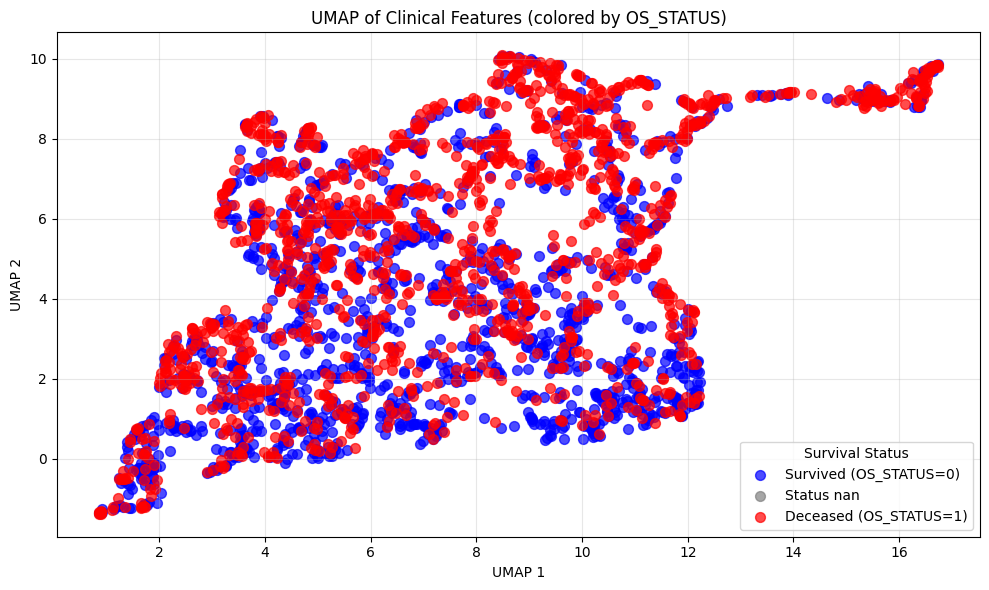

In [13]:
from umap import UMAP

X_umap = UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42).fit_transform(X)

# Create scatter plot colored by OS_STATUS
plt.figure(figsize=(10, 6))
status_labels = {0.0: "Survived (OS_STATUS=0)", 1.0: "Deceased (OS_STATUS=1)"}
colors = {0.0: "blue", 1.0: "red"}

for status in sorted(data_clean["OS_STATUS"].unique()):
    mask = data_clean["OS_STATUS"] == status
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                label=status_labels.get(status, f"Status {status}"),
                color=colors.get(status, "gray"),
                alpha=0.7, s=50)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP of Clinical Features (colored by OS_STATUS)")
plt.legend(title="Survival Status", loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()